# Settling

In this example, we look at some of the options available for running with settling. This is a departure from the assumption of passive transport, or surface only transport, that has been made in the preceeding examples.

The example is carried out in 1D using outputs from the [General Ocean Turbulence Model (*GOTM*)](https://github.com/gotm-model). The *GOTM* outputs have been pre-generated for the example. They have been created using Version 6.0 of the *GOTM* library. We use a *GOTM* configuration for Station L4, which forms part of the [Western Channel Observatory (WCO)](https://www.westernchannelobservatory.org.uk/). The configuration files form part of the [European Regional Seas Ecosystem Model (ERSEM)](https://github.com/pmlmodelling/ersem) suite of [standard setups](https://github.com/pmlmodelling/ersem-setups).

The *GOTM* outputs can be [downloaded here](https://drive.google.com/open?id=15UX7Y9JnuLpnPAz700mzmzd917nTClxR), or recreated from scratch using code and data available at the above links. If you would like to run the code in this notebook interactively, download the data into a directory of your chooising. By default, the notebook will look for these files in the directory `${HOME}/data/pylag_doc`. To change this, simply update the *data_dir* path below.

In [1]:
import os

# Root directory for PyLag example input files
data_dir='{}/data/pylag_doc'.format(os.environ['HOME'])

## Background

As described in the [documentation](../documentation/settling.ipynb), temporal changes in a particle's vertical position within the water column are modeled using an equation of the form:

$$
\begin{equation}
    dZ\left(t\right) = \left(w + \dfrac{\partial K\left(z\right)}{\partial z}\right)dt + \left(2 K \left(z, t \right)\right)^{1/2} dW\left(t\right)
\end{equation}
$$

where $Z\left(t\right)$ is the particle's position vector; $w$ is the vertical velocity; $K$ is the vertical eddy diffusivity; and $dW\left(t\right)$ is a Wiener noise term. Settling is incorporated into the model by letting $w = w_{\mathrm{w}} + w_{\mathrm{s}}$, where $w_{\mathrm{w}}$ is the vertical velocity of the water and $w_{\mathrm{s}}$ is the particle's settling velocity.

The settling velocity is computed using a settling velocity calculator. Here, we demonstrate this using a constant settling velocity calculator, which assigns a fixed settling velocity to all particles. Vertical eddy diffusivities are taken from the GOTM simulation for Station L4.

## Setting particle initial positions

We will create an initial position file in which to record [particle initial positions](../documentation/initial_positions.ipynb). This will be read in by *PyLag* when the model starts up. Here, we start all particles at a depth off at a depth of 1 cm below the sea surface.

In [2]:
from pylag.processing.input import create_initial_positions_file_single_group

# Keep a copy of the cwd
cwd = os.getcwd()

# Initial properties (other than z) of test particles
group_id = 0
x_0 = 0.0
y_0 = 0.0
z_0 = -0.01

# The number of particles in the particle seed
n_particles = 10000

# Create run directory
simulation_dir = '{}/simulations/gotm_settling'.format(cwd)
try:
    os.makedirs(simulation_dir)
except FileExistsError:
    pass

# Create input sub-directory
input_dir = '{}/input'.format(simulation_dir)
try:
    os.makedirs(input_dir)
except FileExistsError:
    pass

# Crate the particle set
x = []
y = []
z = []
for i in range(n_particles):
    x.append(x_0)
    y.append(y_0)
    z.append(z_0)

# Create the initial positions file
file_name = '{}/initial_positions.dat'.format(input_dir)
create_initial_positions_file_single_group(file_name, n_particles, group_id, x, y, z)

## Creating the run configuration file

For this example, a template GOTM run configuration file has been provided. Configuration options specific to settling are described in the [documentation](../documentation/settling.ipynb). Here, we use a constant settling velocity calculator with a settling velocity of 0.005 m/s. At the bottom boundary, we use an absorbing boundary condition, meaning all particles that cross the bottom boundary are retained there. This results in the number of particles remaining in the water column decreasing over time. These and some of the settings controlling the duration of the simulation are described below.

In [3]:
import configparser

config_file_name = './configs/gotm_settling_template.cfg'

cf = configparser.ConfigParser()
cf.read(config_file_name)

print('CONFIGURATION OPTIONS (SELECTED)\n\n')

# Start time
print('Start time: {}'.format(cf.get('SIMULATION', 'start_datetime')))

# End time
print('End time: {}'.format(cf.get('SIMULATION', 'end_datetime')))


# Specify that we are working with GOTM inputs 
print('\nModel name: {}'.format(cf.get('OCEAN_CIRCULATION_MODEL', 'name')))
      
# Use the Milstein diffusive mixing scheme in 1D with a two second time step
print('\nNumerical method: {}'.format(cf.get('NUMERICS', 'num_method')))
print('Iterative method: {}'.format(cf.get('NUMERICS', 'iterative_method')))
print('Time step: {} s'.format(cf.get('NUMERICS', 'time_step_diff')))

# Use a linear interpolation scheme
print('\nVertical interpolation method: {}'.format(cf.get('OCEAN_CIRCULATION_MODEL',
                                                          'vertical_interpolation_scheme')))

# Use a constant settling velocity calculator with a fixed settling velocity
print('\nSettling scheme: {}'.format(cf.get('SETTLING', 'settling_velocity_calculator')))
print('Settling initialisation method: {}'.format(cf.get('CONSTANT_SETTLING_VELOCITY_CALCULATOR',
                                                         'initialisation_method')))
print('Settling velocity: {} m/s'.format(cf.get('CONSTANT_SETTLING_VELOCITY_CALCULATOR',
                                                'settling_velocity')))

# Boundary conditions
print('\nBoundary conditions: {}'.format(cf.get('BOUNDARY_CONDITIONS', 'vert_bound_cond')))

CONFIGURATION OPTIONS (SELECTED)


Start time: 2010-06-25 12:00:00
End time: 2010-06-26 12:00:00

Model name: GOTM

Numerical method: standard
Iterative method: AdvDiff_Milstein_1D
Time step: 2 s

Vertical interpolation method: linear

Settling scheme: Constant
Settling initialisation method: fixed_value
Settling velocity: 0.005 m/s

Boundary conditions: bottom_absorbing


As in the previous examples, we must modify the template configuration file by adding in the correct paths to the input data. With these modifications made, we save the configuration file in the simulation direcotry.

In [4]:
cf.set('OCEAN_CIRCULATION_MODEL', 'data_dir', data_dir)
cf.set('OCEAN_CIRCULATION_MODEL', 'data_file_stem', 'gotm_l4_200')
cf.set('OCEAN_CIRCULATION_MODEL', 'grid_metrics_file', '{}/gotm_l4_200_level.nc'.format(data_dir))
with open("{}/pylag.cfg".format(simulation_dir), 'w') as config:
    cf.write(config)

## Running the model

With the run configuration files saved, we can now run the example. A small driver script has been provided for each simulation, which we will use here to launch *PyLag*. These launch *PyLag* in *serial* mode.

In [5]:
import subprocess

os.chdir('{}'.format(simulation_dir))

try:
    subprocess.call(['./run.sh'])
except:
    print('Run failed.')
    pass

# Return to the cwd
os.chdir(cwd)

## Visualising the result

With the simulation having run, we can plot the impact of settling by looking at the fraction of particles left in the water column as a function of time:

(0.0, 1.0)

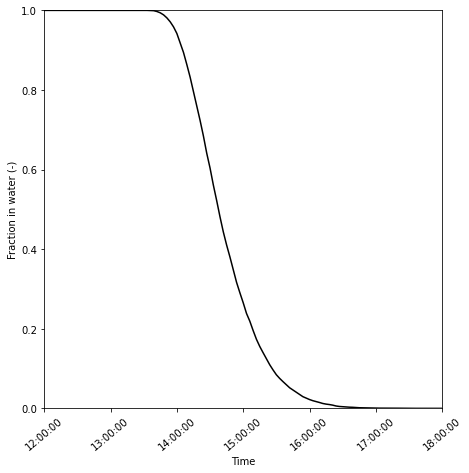

In [6]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as md

# PyLag modules
from pylag.processing.ncview import Viewer
from pylag.processing.plot import create_figure
from datetime import datetime

# Ensure inline plotting
%matplotlib inline

# Font size for plotting
fs = 10

# Date limits
ds = datetime(2010,6,25,12)
de = datetime(2010,6,25,18)

# Date formatter
xfmt = md.DateFormatter('%H:%M:%S')

# Create figure
fig, ax = create_figure(figure_size=(18., 18.), font_size=fs, axis_position=[0.15, 0.2, 0.78, 0.78])

# Open the output file for reading
file_name = '{}/output/pylag_1.nc'.format(simulation_dir)
viewer = Viewer(file_name)

# Plot the fraction of particles left in the water column as a function of time
ax.plot(viewer.date, np.sum(viewer('in_domain'), axis=1) / viewer('in_domain')[:].shape[1],
        color='k')

# Configure plot properties
ax.set_xlabel('Time', fontsize=fs)
ax.set_ylabel('Fraction in water (-)', fontsize=fs)
for label in ax.get_xticklabels():
    label.set_rotation(40)
ax.xaxis.set_major_formatter(xfmt)
ax.set_xlim(ds, de)
ax.set_ylim(0.0, 1.0)

In the simulation, all particles were started from the same position in the water column, 1 cm below the free surface. The depth of the water column at station L4 is 50 m. With a sinking velocity of 0.005 m/s, we see the first particles reach the sea bed approximately two hours after the simulation was started. The is a spread in the time it takes particles to reach the sea bed, which reflects the action of vertical diffusion.

For more details on running with settling, see the model [documentation](../documentation/settling.ipynb).